<a href="https://colab.research.google.com/github/ard18/ratemaking_with_python/blob/main/Ratemaking_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing(Ratemaking) Worker's Compensation Premiums using Actuarial Techniques

# Mount Google Drive

In [41]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns",None)

In [42]:
# export dataset from drive to colab
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/Colab Notebooks/datasets/Project/worker-comp/wkcomp_pos.csv"

dataset = pd.DataFrame(pd.read_csv(filepath))
dataset # the worker's compensation dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_D,CumPaidLoss_D,BulkLoss_D,EarnedPremDIR_D,EarnedPremCeded_D,EarnedPremNet_D,Single,PostedReserve97_D
0,86,Allstate Ins Co Grp,1988,1988,1,367404,70571,127737,400699,5957,394742,0,281872
1,86,Allstate Ins Co Grp,1988,1989,2,362988,155905,60173,400699,5957,394742,0,281872
2,86,Allstate Ins Co Grp,1988,1990,3,347288,220744,27763,400699,5957,394742,0,281872
3,86,Allstate Ins Co Grp,1988,1991,4,330648,251595,15280,400699,5957,394742,0,281872
4,86,Allstate Ins Co Grp,1988,1992,5,354690,274156,27689,400699,5957,394742,0,281872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,44300,Tower Ins Co Of NY,1997,2002,6,334,287,15,4387,3374,1013,1,1187
13196,44300,Tower Ins Co Of NY,1997,2003,7,318,293,2,4387,3374,1013,1,1187
13197,44300,Tower Ins Co Of NY,1997,2004,8,323,300,7,4387,3374,1013,1,1187
13198,44300,Tower Ins Co Of NY,1997,2005,9,310,297,0,4387,3374,1013,1,1187


In [43]:
# dataset columns/features
columns = dataset.columns
print("Columns/Features present in dataset:\n")
for i in columns:
    print(i)

Columns/Features present in dataset:

GRCODE
GRNAME
AccidentYear
DevelopmentYear
DevelopmentLag
IncurLoss_D
CumPaidLoss_D
BulkLoss_D
EarnedPremDIR_D
EarnedPremCeded_D
EarnedPremNet_D
Single
PostedReserve97_D


<ipython-input-44-de39a2653e3e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr(), annot=True, linewidths=0.2, linecolor="black", fmt=".2f")


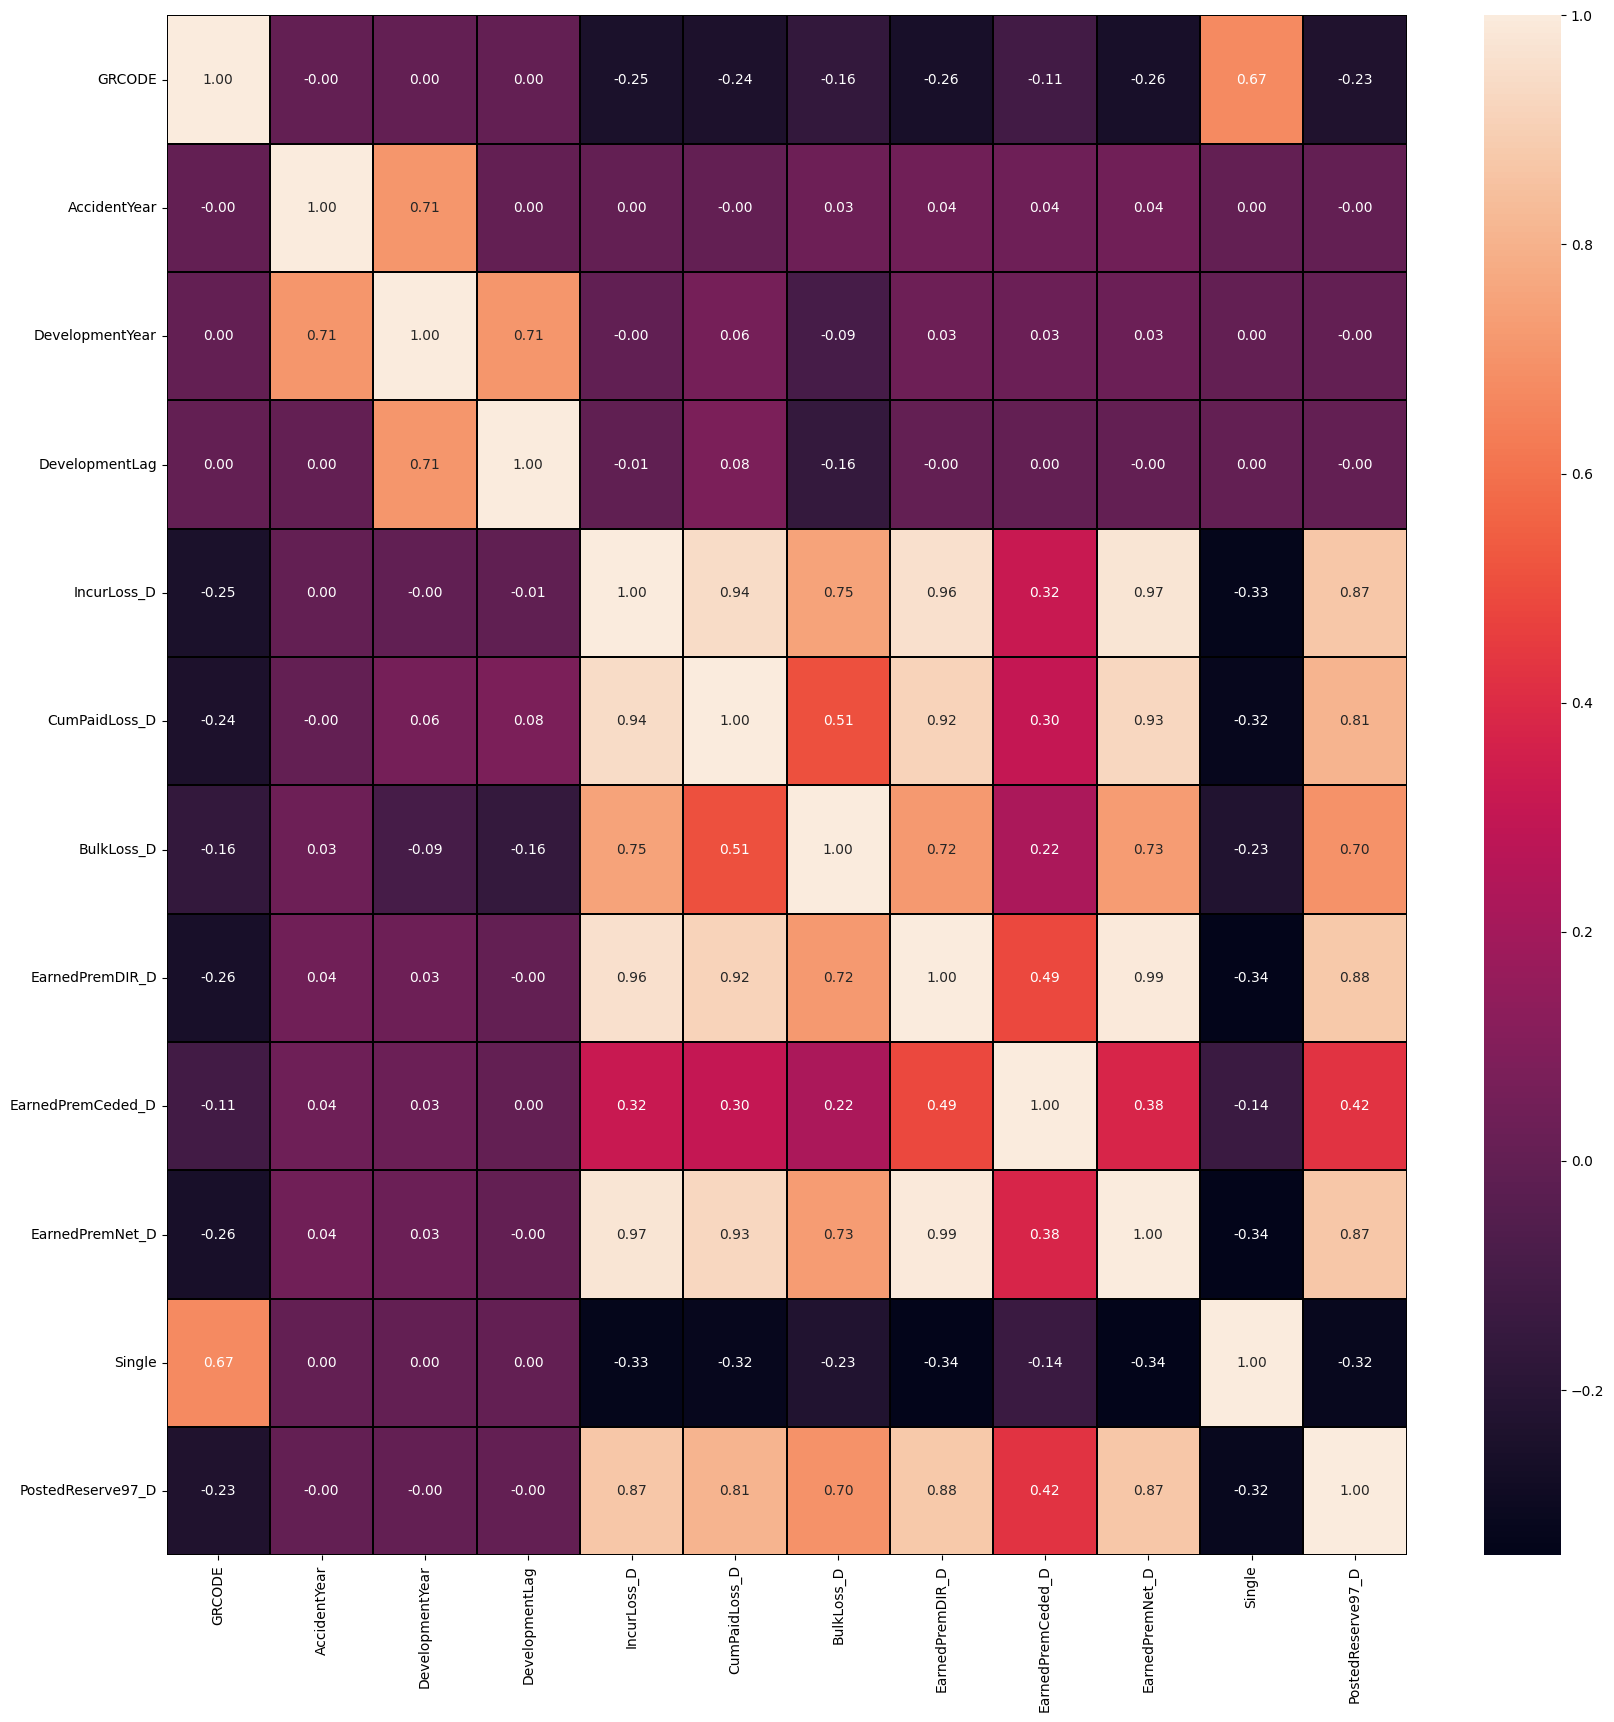

In [44]:
# create a heatmap or correlation map for dataset
plt.figure(figsize=(20, 20))
sns.heatmap(dataset.corr(), annot=True, linewidths=0.2, linecolor="black", fmt=".2f")
plt.show()

We see that there's a strong positive correlation between the following features:
- PostedReserve97_D with IncurLoss_D, CumPaidLoss_D, EarnedPremDIR_D and EarnedPremNet_D  
- EarnedPremNet_D with CumPaidLoss_D and IncurLoss_D

In [45]:
# missing values
if(dataset.isnull().any().sum() == 0):
    print("No missing values present in dataset")
else:
    print("Missing values present in dataset")

No missing values present in dataset


# Choose your Company using GRCODE

In [46]:
# Companies in dataset
dataset["GRCODE-GRNAME"] = dataset['GRCODE'].astype('str')+"-"+dataset['GRNAME']
companies = dataset["GRCODE-GRNAME"]
print("Number of Companies present in dataset {}\n".format(len(pd.unique(companies))))
for i in pd.unique(companies):
    print(i)

Number of Companies present in dataset 132

86-Allstate Ins Co Grp
337-California Cas Grp
353-Celina Mut Grp
388-Federal Ins Co Grp
460-Buckeye Ins Grp
655-FM Global
671-Farm Bureau Of MI Grp
711-Patrons Grp
715-West Bend Mut Ins Grp
965-Secura Ins Co
1066-Island Ins Cos Grp
1090-Kentucky Farm Bureau Mut Ins Grp
1236-Shelter Ins Cos Grp
1252-Penn Miller Grp
1538-Farmers Automobile Grp
1767-State Farm Mut Grp
2135-Erie Ins Exchange Grp
2143-Farmers Alliance Mut & Affiliates
2623-Canal Ins Co Grp
2712-Pennsylvania Natl Ins Grp
3000-Horace Mann Grp
3034-Preferred Risk Mut Grp
3240-NC Farm Bureau Ins Grp
4839-FL Farm Bureau Grp
5010-Capitol Transamerican Grp
5185-Grinnell Mut Grp
5940-American Contractors Ins Grp
6408-Mutual Benefit Grp
6807-Amerisafe Grp
7080-New Jersey Manufacturers Grp
7714-Keystone Ins Grp
8168-Commerce Grp Inc
8427-Farm Bureau Grp
8559-Millers Mut Ins Assoc
8672-Protective Ins Grp
9466-Lumber Ins Cos
10011-Mada Ins Exchange
10022-Agway Ins Co
10048-Hyundai Marine & Fi

## We select a sample of 5 companies

In [47]:
sample_companies = ["Allstate Ins Co Grp", "California Cas Grp", "Celina Mut Grp", "Federal Ins Co Grp", "Farm Bureau of MI Grp"]
grcodes = [86, 337, 353, 388, 671]
df_comp = pd.DataFrame(
    {
        'GRCODE':grcodes,
        'NAME':sample_companies,
    }
)
print("Sample of 5 companies taken for this project. Select a company from the below:")
df_comp

Sample of 5 companies taken for this project. Select a company from the below:


,GRCODE,NAME
0,86,Allstate Ins Co Grp
1,337,California Cas Grp
2,353,Celina Mut Grp
3,388,Federal Ins Co Grp
4,671,Farm Bureau of MI Grp


In [48]:
# select a grcode
slt_comp = int(input("Select a grcode from:"))

Select a grcode from:671


# Functions for Loss Development using Chain-Ladder Method

In [49]:
# python class that consists of 4 different averaging methods for averaging loss-development factors
class AveragingMethods:
    def __init__(self, data):
        '''Here, Data is of type list'''
        self.data = data
    def SimpleAvg(self): # simple average
        sum = 0
        for i in self.data:
            sum += i
        return round( sum/len(self.data), 4)
    def VolumeAvg(self, dt1, dt2): # volume-weighted average
        sum1 = 0
        for i in dt1:
            sum1 += i
        sum2 = 0
        for j in dt2:
            sum2 += j
        return round( sum1/sum2,4)
    def MedialAvg(self): # medial average
        minimum = min(self.data)
        maximum = max(self.data)
        sum = 0
        if len(self.data) > 2:
            for i in self.data:
                sum += i
            sum -= (maximum+minimum)
            return round( sum/(len(self.data)-2),4)
        else:
            return  round( (maximum+minimum)/2,4)
    def GeometricAvg(self): # geometric average
        sum = 1
        for i in self.data:
            sum *= i
        return round( sum**(1/len(self.data)),4)


def LossData(grcode):
    '''This function extracts the loss data of a specific company corresponding to its GRCODE
        Here data is of type: dataframe'''
    company = dataset[dataset["GRCODE"]==grcode]
    return(company)


def createLossTriangle(data):
    '''This function extracts and creates Loss triangles for Cumulative Paid Losses
        Here data is of type: dataframe'''
    trframe = {}      # dict containing loss triangle values for various accident years
    for i in range(1988,1998):
        L = []
        for j in range(i,1998):
            condition = ( (data['AccidentYear']==i) & (data['DevelopmentYear']==j) )
            L.append(int(data.loc[condition]['CumPaidLoss_D']))
        i = int(i)
        trframe[i] = L
    return trframe


def displayTriangleData(data):
    '''This function displays Loss Triangle data
       Here data is of type: dictionary'''
    for i in data.keys():
        print(i, end = "\t\t")
        for j in data[i]:
            print(j, end = "\t")
        print("\n")


def computeLDF(data):
    '''This function computes Loss Development Factors
       Here data is of type: dictionary'''
    trframe = {}
    for i in data.keys():
        L = []
        for j in range(len(data[i])-1):
            ldf = data[i][j+1]/data[i][j]
            L.append( round(ldf,4) )
        i = int(i)
        trframe[i] = L
    return trframe


def computeAverageLDF(ldf_info, loss_info):
    '''This function computes various Averages of Loss Development Factors
       Here data is of type: dictionary'''
    print("Available averaging methods:\n\
            1. Simple Average :- Latest 5\n\
            2. Volume-Weighted Average :- Latest 5\n\
            3. Medial Average :- Latest 5\n\
            4. Geometric Average :- Latest 5\n")
    DK = list(ldf_info.keys())
    DK = sorted(DK, reverse=True)
    trframe = {
        'SimpleAvg':[],
        'VolumeAvg':[],
        'MedialAvg':[],
        'GeometricAvg':[]
    }
    # for Medial, Simple and Geometric Averages
    for i in range(0,10):
        L = []
        c = 1
        for j in DK:
            try:    # to avoid Index Out of Bounds
                if ldf_info[j][i] and c<=5:
                    L.append(ldf_info[j][i])
                    c+=1
            except:
                pass
        if(L!=[]):
            obj = AveragingMethods(L)               # object of class Averaging methods
            simp_avg = obj.SimpleAvg()
            med_avg  = obj.MedialAvg()
            geo_avg  = obj.GeometricAvg()
            trframe['SimpleAvg'].append(simp_avg)
            trframe['MedialAvg'].append(med_avg)
            trframe['GeometricAvg'].append(geo_avg)
    # only for Volume-Weighted Average
    for i in range(1,10):
        L1 = []
        L2 = []
        c = 1
        for j in DK:
            try:
                if loss_info[j][i] and loss_info[j][i-1] and c<=5:
                    L1.append(loss_info[j][i])
                    L2.append(loss_info[j][i-1])
                    c+=1
            except:
                pass
        if(L1!=[] and L2!=[]):
            obj = AveragingMethods(L1)
            vol_avg = obj.VolumeAvg(L1, L2)
            trframe['VolumeAvg'].append(vol_avg)
    return trframe



# the loss data of selected company
loss_data = LossData(slt_comp)

# the loss development triangle
print("Loss Development Triangle\n")
loss_triangle = createLossTriangle(loss_data)
displayTriangleData(loss_triangle)
print("\n")

print("Loss Development Factors (Age-to-Age factors)\n")
ldf_triangle = computeLDF(loss_triangle)
displayTriangleData(ldf_triangle)
print("\n")

Loss Development Triangle

1988		1346	3389	4666	5331	5719	6097	6126	6292	6368	6415	

1989		1411	3641	4729	5352	5935	6032	6061	6222	6292	

1990		1424	4460	5791	6949	6966	7324	7596	7730	

1991		2355	6208	8191	8368	8895	9162	9564	

1992		2544	7554	8008	9684	10637	10825	

1993		3512	6745	9173	10286	10789	

1994		2708	7360	10084	11434	

1995		2609	6240	8280	

1996		2652	5332	

1997		2192	



Loss Development Factors (Age-to-Age factors)

1988		2.5178	1.3768	1.1425	1.0728	1.0661	1.0048	1.0271	1.0121	1.0074	

1989		2.5804	1.2988	1.1317	1.1089	1.0163	1.0048	1.0266	1.0113	

1990		3.132	1.2984	1.2	1.0024	1.0514	1.0371	1.0176	

1991		2.6361	1.3194	1.0216	1.063	1.03	1.0439	

1992		2.9693	1.0601	1.2093	1.0984	1.0177	

1993		1.9206	1.36	1.1213	1.0489	

1994		2.7179	1.3701	1.1339	

1995		2.3917	1.3269	

1996		2.0106	

1997		





### Making dataframe out of dictionary for triangular loss data

In [50]:
# Determine the maximum length of the arrays
max_length = max(len(arr) for arr in loss_triangle.values())
# Pad the arrays with NaN to make them all the same length
data_padded = {key: arr + [np.nan] * (max_length - len(arr)) for key, arr in loss_triangle.items()}
# Create DataFrame from the padded dictionary
loss_df = pd.DataFrame.from_dict(data_padded)
loss_df = loss_df.T
for i in range(0,max_length):
    loss_df.rename(columns={i:(i+1)*12,}, inplace=True)
print("Loss Triangle Dataframe")
loss_df

Loss Triangle Dataframe


,12,24,36,48,60,72,84,96,108,120
1988,1346.0,3389.0,4666.0,5331.0,5719.0,6097.0,6126.0,6292.0,6368.0,6415.0
1989,1411.0,3641.0,4729.0,5352.0,5935.0,6032.0,6061.0,6222.0,6292.0,NaN
1990,1424.0,4460.0,5791.0,6949.0,6966.0,7324.0,7596.0,7730.0,NaN,NaN
1991,2355.0,6208.0,8191.0,8368.0,8895.0,9162.0,9564.0,NaN,NaN,NaN
1992,2544.0,7554.0,8008.0,9684.0,10637.0,10825.0,NaN,NaN,NaN,NaN
1993,3512.0,6745.0,9173.0,10286.0,10789.0,NaN,NaN,NaN,NaN,NaN
1994,2708.0,7360.0,10084.0,11434.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,2609.0,6240.0,8280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,2652.0,5332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,2192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Select LDF.
avg_ldf = computeAverageLDF(ldf_triangle, loss_triangle)
for i in avg_ldf.keys():
    print(i,"\t",avg_ldf[i],"\n")

try:
    chosen_Ldf = input("Select an averaging method from the above:")
    selected_Ldf = avg_ldf[chosen_Ldf]
except:
    print("Incorrect option entered. Taking Default option: Volume-Weighted Average.")
    selected_Ldf = avg_ldf['VolumeAvg']
for i in selected_Ldf:
    print(i,"\t")

# We select an arbitrary tail factor
tail = 1.0000
selected_Ldf.append(tail)
selected_Ldf = selected_Ldf[::-1]

# Cumulative Loss Development factors
cdf = []
for i in range(1, len(selected_Ldf)+1):
    f = 1
    for j in range(0, i):
        f*=selected_Ldf[j]
    cdf.append( round( f,4) )

print("\nCumulative Development Factor (CDF):\n", cdf[::-1])


Available averaging methods:
            1. Simple Average :- Latest 5
            2. Volume-Weighted Average :- Latest 5
            3. Medial Average :- Latest 5
            4. Geometric Average :- Latest 5

SimpleAvg 	 [2.402, 1.2873, 1.1372, 1.0643, 1.0363, 1.0227, 1.0238, 1.0117, 1.0074] 

VolumeAvg 	 [2.3694, 1.2823, 1.1327, 1.0636, 1.0338, 1.0256, 1.0233, 1.0117, 1.0074] 

MedialAvg 	 [2.3734, 1.3354, 1.1517, 1.0701, 1.033, 1.021, 1.0266, 1.0117, 1.0074] 

GeometricAvg 	 [2.3685, 1.2817, 1.1352, 1.0636, 1.0361, 1.0225, 1.0238, 1.0117, 1.0074] 

Select an averaging method from the above:VolumeAvg
2.3694 	
1.2823 	
1.1327 	
1.0636 	
1.0338 	
1.0256 	
1.0233 	
1.0117 	
1.0074 	

Cumulative Development Factor (CDF):
 [4.0476, 1.7083, 1.3322, 1.1761, 1.1058, 1.0696, 1.0429, 1.0192, 1.0074, 1.0]


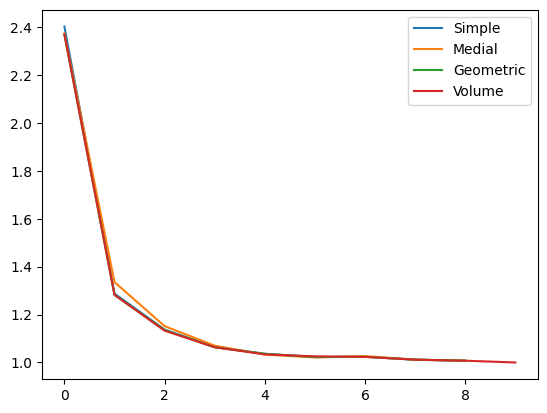

In [52]:
plt.plot(avg_ldf['SimpleAvg'])
plt.plot(avg_ldf['MedialAvg'])
plt.plot(avg_ldf['GeometricAvg'])
plt.plot(avg_ldf['VolumeAvg'])

plt.legend( ['Simple','Medial','Geometric','Volume'] , loc='upper right')

In [53]:
# Projected Ultimate Losses
proj_ultLosses = {}
for i in range(0, len(cdf)):
    for j in range(0, len(loss_triangle)):
        if(i==j):
            proj_ultLosses[ list(loss_triangle.keys())[j] ] = round( list(loss_triangle.values())[i][-1]*cdf[i],4)
print("Projected Ulimate Losses\n")
for i in proj_ultLosses.keys():
    print(i,"\t==>",proj_ultLosses[i])

Projected Ulimate Losses

1988 	==> 6415.0
1989 	==> 6338.5608
1990 	==> 7878.416
1991 	==> 9974.2956
1992 	==> 11578.42
1993 	==> 11930.4762
1994 	==> 13447.5274
1995 	==> 11030.616
1996 	==> 9108.6556
1997 	==> 8872.3392


Lets evaluate the closeness of our projected ultimate losses to the actual ultimate losses.

In [54]:
# metrics used: mean absolute error, and r^2 coefficient
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
# Actual Ultimate Losses
act_ultLosses = {}
for i in range(1988,1998):
        condition = ( (loss_data['AccidentYear']==i) & (loss_data['DevelopmentLag']==10) )
        act_ultLosses[i] = int( loss_data.loc[condition]['CumPaidLoss_D'])
print("Actual Ulimate Losses\n")
for i in act_ultLosses.keys():
    print(i,"\t==>",act_ultLosses[i])
mae1 = mae(list(act_ultLosses.values()), list(proj_ultLosses.values()))
print( "\nMean Absolute Error =",mae1 )
print("\nR^2 coefficient =", r2(list(act_ultLosses.values()), list(proj_ultLosses.values()) ) )

Actual Ulimate Losses

1988 	==> 6415
1989 	==> 6357
1990 	==> 7908
1991 	==> 9886
1992 	==> 11481
1993 	==> 11758
1994 	==> 13515
1995 	==> 10818
1996 	==> 9217
1997 	==> 9226

Mean Absolute Error = 114.83087999999971

R^2 coefficient = 0.9951944243775869


## Using GLMs for projecting Ultimate Losses

In [55]:
import statsmodels.api as sm
import warnings
def GLM_UltClaims(dataset):
    '''The dataset used here is a dataframe.
    This function outputs a dataframe having projected the lower half of the original dataset, i.e., projected losses'''
    # dataset is a dataframe
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    i = 0
    k = 9
    while i<9:
        x_train = [ dataset.iloc[j,i] for j in range(0,k)   ]
        y_train = [ dataset.iloc[j,i+1] for j in range(0,k) ]
        x_test =  [ dataset.iat[j,i] for j in range(k,10)   ]

        glm_model = sm.GLM(y_train,x_train,family=sm.families.Gaussian()) # using gaussian glm
        model_results = glm_model.fit(method="bfgs")
        y_test = model_results.predict(x_test)

        for j in range(0,len(y_test)):
            dataset.iat[k+j,i+1] = y_test[j]
        i+=1
        k-=1
    return dataset

data = GLM_UltClaims(loss_df)
print("GLM projected claims in the lower triangle")
data

GLM projected claims in the lower triangle


,12,24,36,48,60,72,84,96,108,120
1988,1346.0,3389.000000,4666.000000,5331.000000,5719.000000,6097.000000,6126.000000,6292.000000,6368.000000,6415.000000
1989,1411.0,3641.000000,4729.000000,5352.000000,5935.000000,6032.000000,6061.000000,6222.000000,6292.000000,6338.439070
1990,1424.0,4460.000000,5791.000000,6949.000000,6966.000000,7324.000000,7596.000000,7730.000000,7820.203302,7877.921511
1991,2355.0,6208.000000,8191.000000,8368.000000,8895.000000,9162.000000,9564.000000,9782.193196,9896.344053,9969.385537
1992,2544.0,7554.000000,8008.000000,9684.000000,10637.000000,10825.000000,11133.997293,11388.008424,11520.897940,11605.929693
1993,3512.0,6745.000000,9173.000000,10286.000000,10789.000000,11124.703426,11442.255689,11703.299430,11839.868156,11927.254118
1994,2708.0,7360.000000,10084.000000,11434.000000,12169.501346,12548.159544,12906.344055,13200.789523,13354.832835,13453.400226
1995,2609.0,6240.000000,8280.000000,9359.238409,9961.279029,10271.227634,10564.417614,10805.434348,10931.525662,11012.207462
1996,2652.0,5332.000000,6844.958055,7737.149074,8234.847479,8491.077576,8733.453556,8932.698657,9036.936550,9103.635045
1997,2192.0,5289.542673,6790.453437,7675.540172,8169.275533,8423.465336,8663.911340,8861.569904,8964.977778,9031.145170


In [56]:
# GLM projected ultimate Losses
glmUlt_Losses = {}
for i in range(0,len(loss_triangle.keys())):
    glmUlt_Losses[list(loss_triangle.keys())[i]] = data.iat[i,9]
print("GLM Projected Ulimate Losses\n")
for i in glmUlt_Losses.keys():
    print(i,"\t==>",glmUlt_Losses[i])
mae2 = mae(list(act_ultLosses.values()), list(glmUlt_Losses.values()) )
print( "\nMean Absolute Error =",mae2)
print("\nR^2 coefficient =", r2(list(act_ultLosses.values()), list(glmUlt_Losses.values() ) ))

GLM Projected Ulimate Losses

1988 	==> 6415.0
1989 	==> 6338.439070351758
1990 	==> 7877.921510727627
1991 	==> 9969.38553730813
1992 	==> 11605.929693189173
1993 	==> 11927.25411755138
1994 	==> 13453.400225784897
1995 	==> 11012.207462260796
1996 	==> 9103.63504498937
1997 	==> 9031.145170276423

Mean Absolute Error = 99.02357881794032

R^2 coefficient = 0.9970369593897458


### Select the losses of the method producing lower MAE

In [77]:
if mae1 < mae2:
    print("Chain-Ladder Projected Losses selected")
    ULT_LOSSES = proj_ultLosses
else:
    print("GLM Projected Losses selected")
    ULT_LOSSES = glmUlt_Losses
for i in ULT_LOSSES.keys():
    print(i,"===>",ULT_LOSSES[i])

GLM Projected Losses selected
1988 ===> 6415.0
1989 ===> 6338.439070351758
1990 ===> 7877.921510727627
1991 ===> 9969.38553730813
1992 ===> 11605.929693189173
1993 ===> 11927.25411755138
1994 ===> 13453.400225784897
1995 ===> 11012.207462260796
1996 ===> 9103.63504498937
1997 ===> 9031.145170276423


# Calculating Rate and Benefit Adjustment Factors
We use a simple general formula derived by Richard A. Bill for automating the calculation of rate and benefit adjustment factors. This is based on the parallelogram method. More details on the formula can be found in the paper by Richard A. Bill on:
https://www.casact.org/abstract/generalized-earned-premium-rate-adjustment-factors


We exclude any fluctuations arising due to legal changes.

## Adjusting Premiums for Rate Changes


In [59]:
# Net Premium Earned (Earned Premium - Ceded Earned Premium(or Reinsurance costs))
net_prem_earned = {}
for i in range(1988,1998):
    net_prem_earned[i] = list( loss_data[loss_data['AccidentYear']==i]['EarnedPremNet_D'] )[0]

print("Net Premium Earned\n")
for i in net_prem_earned.keys():
    print(i,"\t==>",net_prem_earned[i])

Net Premium Earned

1988 	==> 7122
1989 	==> 7588
1990 	==> 10232
1991 	==> 12731
1992 	==> 16847
1993 	==> 21327
1994 	==> 21686
1995 	==> 24955
1996 	==> 22316
1997 	==> 20975


We will assume some rate changes. (Other rate changes can be assumed)

In [60]:
import datetime
# Assume rate changes (values taken similar to those in Massachusetts Rate Filings)
rate_changes = {
            datetime.date(1988,4,1):0.198, #datetime.date(1989,1,1):0.1,
                datetime.date(1990,7,1):0.262, #datetime.date(1991,4,1):-0.04,
            datetime.date(1991,5,1):0.113,  #datetime.date(1992,3,1):0.07,
            datetime.date(1993,8,1):0.062, #datetime.date(1994,2,1):0.08,
            datetime.date(1996,5,1):-0.122
                }
# first calculate the rate change indeces
rates = list(rate_changes.values())
rate_index =[1.00]+[ (1+i) for i in rates ] # including initial index of segment without changes = 1.00 (rate change = 0%)
print("Rate change indeces:\n",rate_index)
cum_index = []
f = 1
for i in rate_index:
    f *= i
    cum_index.append( round(f, 4))
print("Cumulative rate change indeces:\n",cum_index)
current_cum_rate_index = cum_index[-1]
print("Current Cumulative Rate Level Index =",current_cum_rate_index)

Rate change indeces:
 [1.0, 1.198, 1.262, 1.113, 1.062, 0.878]
Cumulative rate change indeces:
 [1.0, 1.198, 1.5119, 1.6827, 1.787, 1.569]
Current Cumulative Rate Level Index = 1.569


In [61]:
# To calculate the portions earned by premiums under each rate change
import datetime
T = 1; E = 1;

def months_between(date1,date2):
    '''This function calculates the difference between 2 given dates in months
    date1, date2 are in datetime.date() format'''
    m1=date1.year*12+date1.month
    m2=date2.year*12+date2.month
    months=m1-m2    # difference between the dates

    return months/12



def find_remains(rate_dates, earned_prem_year, L):
    '''This function calculates the remaining portions of earned premium under the rate changes
       rate_dates is a dictionary containing the dates of rate changes, earned_prem_year is the year whose premiums are being adjusted, L is a list'''
    if L!=[]:
        L.append(0) # appending 0 as a means for calculating the last portion
        to_return = []  # the list that contains the portions
        max = 1 # maximum value (total area of an year of earned premium)
        for i in range(0, len(L)):
            if L[i]!=0:
                diff = max - L[i]   # calculate remaining portion
                to_return.append(round( diff,5))
                max = L[i]
                if L[i+1]==0:   # for the last portion to be appended
                    to_return.append(round( max,5))
            else:
                to_return.append(0)

        if to_return.count(0) == len(to_return):
            to_return = earnedPortion_ForUnaffectedYear(rate_dates, earned_prem_year, to_return)

        to_return.pop()
        return to_return



def earnedPortion_ForUnaffectedYear(rate_dates, earned_prem_year, L):
    '''This function sets the portion earned by premium for that year as 1 if there are no rate changes affecting that year
    rate_dates is a dictionary containing the dates of rate changes, earned_prem_year is the year whose premiums are being adjusted, L is a list'''
    c = 0
    start_date = datetime.date(earned_prem_year,1,1)
    for i in rate_dates:
        if( months_between(i, start_date)>0 ):      # checking where to insert 1
            break
        else:
            c+=1
    L.insert(c,1)   # insert 1 as portion earned by premium
    return L



def earnedPortion(rate_dates, earned_prem_years):
    '''This function calculates the portion of earned premium under given rate changes
    rate_dates is a dictionary containing the dates of rate changes and earned_prem_years is also a dictionary containing the years in which premium is earned'''
    portion = {}
    for i in earned_prem_years:
        portion[i] = []
    for i in earned_prem_years:
        start_date = datetime.date(i,1,1)
        for j in rate_dates:

            if months_between(j, start_date)<1 and months_between(j, start_date)>-1:
                # algorithm for calculating portions of earned premium
                D = months_between(j, start_date)

                A = D+T
                B = max( A-E, 0 )
                C = max( D, 0 )

                P = 1 - ( (pow(A,2)-pow(B,2)-pow(C,2)) / (2*E*T) )
                portion[i].append( round(P, 5))
            else:
                portion[i].append(0)

    # print(portion)
    for i in portion.keys():
        portion[i] = find_remains(rate_dates, i, portion[i])
    return(portion)


rate_effec_dates = list( rate_changes.keys())
years_toAdjust = list( net_prem_earned.keys() )
earned_NetPremPortion = earnedPortion(rate_effec_dates, years_toAdjust)
print("The portion earned by the premium in the years w.r.t. the rate changes are:\n",earned_NetPremPortion)

The portion earned by the premium in the years w.r.t. the rate changes are:
 {1988: [0.71875, 0.28125, 0, 0, 0, 0], 1989: [0.03125, 0.96875, 0, 0, 0, 0], 1990: [0, 0.875, 0.125, 0, 0, 0], 1991: [0, 0.125, 0.65278, 0.22222, 0, 0], 1992: [0, 0, 0.05556, 0.94444, 0, 0], 1993: [0, 0, 0, 0.91319, 0.08681, 0], 1994: [0, 0, 0, 0.17014, 0.82986, 0], 1995: [0, 0, 0, 0, 1, 0], 1996: [0, 0, 0, 0, 0.77778, 0.22222], 1997: [0, 0, 0, 0, 0.05556, 0.94444]}


In [62]:
# Average Cumulative Rate Level Indices

def AvgCumulIndices(L, cumul_indices):
    '''This function calculates the average cumulative rate level indices for the earned premium
    L, cumul_indices are numpy arrays where L contains the portions of earned premiums and cumul_indices contains the cumulative rate level indices'''
    prod = L*cumul_indices
    sum = 0
    for i in prod:
        sum+=i
    return round(sum, 5)

# changing to numpy arrays
for i in earned_NetPremPortion.keys():
    earned_NetPremPortion[i] = np.array(earned_NetPremPortion[i])
cum_index = np.array(cum_index)

avg_CumulIndices = {}
for i in earned_NetPremPortion.keys():
    avg_CumulIndices[i] = AvgCumulIndices(earned_NetPremPortion[i], cum_index)

print("\nThe Average Cumulative Rate Level Indices are:")
for i in avg_CumulIndices.keys():
    print(i,"\t==>",avg_CumulIndices[i])


The Average Cumulative Rate Level Indices are:
1988 	==> 1.05569
1989 	==> 1.19181
1990 	==> 1.23724
1991 	==> 1.51062
1992 	==> 1.67321
1993 	==> 1.69175
1994 	==> 1.76925
1995 	==> 1.787
1996 	==> 1.73856
1997 	==> 1.58111


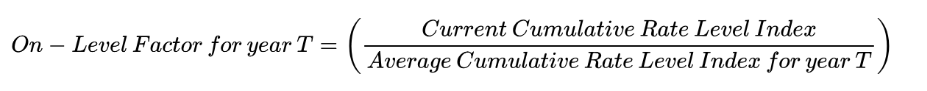

In [63]:
# On-Level Factors for the premiums
onlevel = {}
print("Current Cumulative Rate Level Index =",current_cum_rate_index)
for i in avg_CumulIndices.keys():
    onlevel[i] = round( current_cum_rate_index/avg_CumulIndices[i], 5 )
print("\nThe On-Level Factors are:")
for i in onlevel.keys():
    print(i,"\t==>",onlevel[i])

Current Cumulative Rate Level Index = 1.569

The On-Level Factors are:
1988 	==> 1.48623
1989 	==> 1.31649
1990 	==> 1.26815
1991 	==> 1.03865
1992 	==> 0.93772
1993 	==> 0.92744
1994 	==> 0.88682
1995 	==> 0.87801
1996 	==> 0.90247
1997 	==> 0.99234


In [64]:
# On-Levelling the Premiums
AdjustedPrem = {}
for i in onlevel.keys():
    AdjustedPrem[i] = round( net_prem_earned[i] * onlevel[i], 5)
print("The On-Level Net Premiums are:\n")
for i in AdjustedPrem.keys():
    print(i,"\t==>",AdjustedPrem[i])

The On-Level Net Premiums are:

1988 	==> 10584.93006
1989 	==> 9989.52612
1990 	==> 12975.7108
1991 	==> 13223.05315
1992 	==> 15797.76884
1993 	==> 19779.51288
1994 	==> 19231.57852
1995 	==> 21910.73955
1996 	==> 20139.52052
1997 	==> 20814.3315


## Adjusting Losses for Benefit Changes

In [65]:
# Assume benefit changes (Other benefit changes can be assumed)
benefit_changes = {
            # datetime.date(1988,4,1):0.05,
                 datetime.date(1989,1,1):0.1,
            # datetime.date(1990,7,1):-0.02,
                 datetime.date(1991,4,1):-0.04,
            # datetime.date(1991,5,1):0.11,
                 datetime.date(1992,3,1):0.07,
            # datetime.date(1993,8,1):-0.05,
                 datetime.date(1994,2,1):0.08,
            # datetime.date(1996,8,1):0.15
                }
# first calculate the benefit change indeces
benefits = list(benefit_changes.values())
benefit_index =[1.00]+[ (1+i) for i in benefits ] # including initial index without changes = 1.00 (rate change = 0%)
print("Benefit change indeces:\n",benefit_index)
loss_lvl = []
f = 1
for i in benefit_index:
    f *= i
    loss_lvl.append( round(f, 4))
print("Loss Level indeces (Cumulative indeces):\n",loss_lvl)
current_loss_lvl = loss_lvl[-1]
print("Current Loss Level =",current_loss_lvl)

Benefit change indeces:
 [1.0, 1.1, 0.96, 1.07, 1.08]
Loss Level indeces (Cumulative indeces):
 [1.0, 1.1, 1.056, 1.1299, 1.2203]
Current Loss Level = 1.2203


In [76]:
import datetime
T = 1; E = 1;

def months_between(date1,date2):
    '''This function calculates the difference between 2 given dates in months
    date1, date2 are in datetime.date() format'''
    m1=date1.year*12+date1.month
    m2=date2.year*12+date2.month
    months=m1-m2    # difference between the dates

    return months/12



def find_remains(ben_dates, loss_year, L):
    '''This function calculates the remaining portions of earned premium under the rate changes
       ben_dates is a list containing the dates of benefit changes, loss_year is the year whose losses are being adjusted, L is a list'''
    if L!=[]:
        L.append(0) # appending 0 as a means for calculating the last portion
        to_return = []  # the list that contains the portions
        max = 1 # maximum value (total area of an year of losses)
        for i in range(0, len(L)):
            if L[i]!=0:
                diff = max - L[i]   # calculate remaining portion
                to_return.append(round( diff,5))
                max = L[i]
                if L[i+1]==0:   # for the last portion to be appended
                    to_return.append(round( max,5))
            else:
                to_return.append(0)

        if to_return.count(0) == len(to_return):
            to_return = Portion_ForUnaffectedYear(ben_dates, loss_year, to_return)

        to_return.pop()
        return to_return



def Portion_ForUnaffectedYear(ben_dates, loss_year, L):
    '''This function sets the portion earned by premium for that year as 1 if there are no rate changes affecting that year
    ben_dates is a list containing the dates of benefit changes, loss_year is the year whose losses are being adjusted, L is a list'''
    c = 0
    start_date = datetime.date(loss_year,1,1)
    for i in ben_dates:
        if( months_between(i, start_date)>0 ):      # checking where to insert 1
            break
        else:
            c+=1
    L.insert(c,1)   # insert 1 as portion earned by premium
    return L



def LossPortion(ben_dates, loss_years):
    '''This function calculates the portion of earned premium under given rate changes
    ben_dates is a list containing the dates of benefit changes and loss_years is also a list containing the years in which losses occur'''
    portion = {}
    for i in loss_years:
        portion[i] = []
    for i in loss_years:
        start_date = datetime.date(i,1,1)
        for j in ben_dates:

            if months_between(j, start_date)<1 and months_between(j, start_date)>-1:
                # algorithm for calculating portions of earned premium
                D = months_between(j, start_date)

                A = D+T
                B = max( A-E, 0 )
                C = max( D, 0 )

                P = 1 - ( (pow(A,2)-pow(B,2)-pow(C,2)) / (2*E*T) )
                portion[i].append( round(P, 5))
            else:
                portion[i].append(0)

    for i in portion.keys():
        portion[i] = find_remains(ben_dates, i, portion[i])
    return(portion)


ben_effec_dates = list( benefit_changes.keys())
years_toAdjust = list( ULT_LOSSES.keys() )
LossesPortion = LossPortion(ben_effec_dates, years_toAdjust)
print("The portion of the losses in the years w.r.t. the benefit changes are:\n")
for i in LossesPortion.keys():
    print(i,"===>",LossesPortion[i])

The portion of the losses in the years w.r.t. the benefit changes are:

1988 ===> [1, 0, 0, 0, 0]
1989 ===> [0.5, 0.5, 0, 0, 0]
1990 ===> [0, 1, 0, 0, 0]
1991 ===> [0, 0.71875, 0.28125, 0, 0]
1992 ===> [0, 0.03125, 0.62153, 0.34722, 0]
1993 ===> [0, 0, 0.01389, 0.98611, 0]
1994 ===> [0, 0, 0, 0.57986, 0.42014]
1995 ===> [0, 0, 0, 0.00347, 0.99653]
1996 ===> [0, 0, 0, 0, 1]
1997 ===> [0, 0, 0, 0, 1]


In [67]:
# Average Loss Levels

def AvgLossLevel(L, loss_levels):
    '''This function calculates the average Loss levels for the historical periods
    L, loss_levels are numpy arrays where L contains the portions of losses and loss_levels contains the loss levels'''
    prod = L*loss_levels
    sum = 0
    for i in prod:
        sum+=i
    return round(sum, 5)

for i in LossesPortion.keys():
    LossesPortion[i] = np.array(LossesPortion[i])
loss_lvl = np.array(loss_lvl)

avg_LossLvl = {}
for i in LossesPortion.keys():
    avg_LossLvl[i] = AvgLossLevel(LossesPortion[i], loss_lvl)

print("\nThe Average Loss Levels are:")
for i in avg_LossLvl.keys():
    print(i,"\t==>",avg_LossLvl[i])


The Average Loss Levels are:
1988 	==> 1.0
1989 	==> 1.05
1990 	==> 1.1
1991 	==> 1.08762
1992 	==> 1.08303
1993 	==> 1.12887
1994 	==> 1.16788
1995 	==> 1.21999
1996 	==> 1.2203
1997 	==> 1.2203


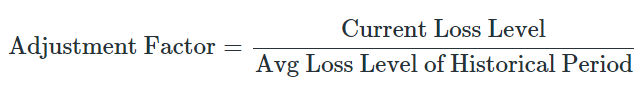

In [68]:
# Adjustment Factors
adjusts = {}
print("Current Loss Level =",current_loss_lvl)
for i in avg_LossLvl.keys():
    adjusts[i] = round( current_loss_lvl/avg_LossLvl[i], 5 )
print("\nThe Adjustment Factors are:")
for i in adjusts.keys():
    print(i,"\t==>",adjusts[i])

Current Loss Level = 1.2203

The Adjustment Factors are:
1988 	==> 1.2203
1989 	==> 1.16219
1990 	==> 1.10936
1991 	==> 1.12199
1992 	==> 1.12675
1993 	==> 1.08099
1994 	==> 1.04488
1995 	==> 1.00025
1996 	==> 1.0
1997 	==> 1.0


In [69]:
# Adjusting the Losses
AdjustedLosses = {}
for i in adjusts.keys():
    AdjustedLosses[i] = round( ULT_LOSSES[i] * adjusts[i], 5)
print("The Adjusted Losses are:\n")
for i in AdjustedLosses.keys():
    print(i,"\t==>",AdjustedLosses[i])

The Adjusted Losses are:

1988 	==> 7828.2245
1989 	==> 7366.4705
1990 	==> 8739.45101
1991 	==> 11185.55088
1992 	==> 13076.98128
1993 	==> 12893.24243
1994 	==> 14057.18883
1995 	==> 11014.96051
1996 	==> 9103.63504
1997 	==> 9031.14517


# Trending Loss Ratios

### We are getting data related to Annual Inflation Rates by country from World Bank's website: [data.worldbank.org](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=US&view=chart)

In [70]:
# Lets work on Inflation Rates first
filepath = "/content/drive/MyDrive/Colab Notebooks/datasets/Project/worker-comp/605_InflationRates.xlsx"

inflation_rates = pd.DataFrame(pd.read_excel(filepath, sheet_name="justTheInflation"))
inflation_rates

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.032258,1.073966,3.643045,3.121868,3.991628,5.836688,5.555556,3.873375,5.215560,6.311080,3.361391,3.225288,2.999948,1.869489,2.280372,4.044021,2.883604,3.315247,3.656365,2.529129,3.397787,3.608024,5.392568,8.955987,-2.135429,2.078141,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.598394,15.224099,11.216471,14.238055,12.526893,15.069850,15.066512,14.461591,12.139918,11.567524,10.983863,13.006566,13.891972,12.563443,12.522254,12.558202,12.457914,17.678100,16.167612,13.135661,14.852815,12.288591,9.706586,10.249599,7.495256,7.819865,8.601485,5.840354,8.763754,7.449700,5.023421,8.558038,8.898164,8.450775,12.566645,8.954218,5.537538,8.971206,9.158707,5.750981,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.773751
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.686269,6.784597,8.680571,26.418664,-6.811161,2.178538,11.804186,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.799211,12.059765,10.671937,11.250000,7.354926,5.950965,0.248789,2.523659,0.869287,1.057361,1.741888,-0.062999,0.553456,31.841017,10.563289,4.914240,3.997142,4.471125,0.372266,2.530775,4.361529,3.188693,1.760904,0.694336,5.631634,4.415900,3.607368,8.452976,3.282440,1.784844,4.018699,4.578375,2.439201,1.768436,2.130817,1.487416,1.764635,1.784050,1.760112,2.437609,3.653533,7.967574
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.783784,299.509804,1378.527607,949.792531,2666.450593,4145.105982,219.176721,107.284822,248.195902,324.996872,152.561022,108.897436,98.224144,43.542107,22.953514,13.305210,12.251497,12.475829,13.730284,14.469656,13.482468,10.277905,8.777814,7.280387,9.353840,30.698958,29.842578,19.630594,17.079704,22.271564,25.754266,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.084813,-1.064727,-1.385189,0.621647,4.358497,9.350418,-2.410264,3.480508,7.336418,2.476738,1.767324,0.428958,-0.536929,0.273169,1.488234,1.053798,2.675992,0.198228,3.353691,11.580510
262,"Yemen, Rep.",YEM,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.000000,29.411765,35.752298,49.394155,55.081107,30.733733,2.176727,5.976509,8.660219,4.590000,11.911591,12.238534,10.832361,12.515095,11.8

In [71]:
# inflation rates in USA
inf_us = inflation_rates[inflation_rates['Country Name'] == "United States"]
inf_us

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
251,United States,USA,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,3.015075,2.772786,4.271796,5.462386,5.838255,4.292767,3.272278,6.17776,11.054805,9.143147,5.744813,6.501684,7.630964,11.254471,13.549202,10.334715,6.131427,3.212435,4.300535,3.545644,1.898048,3.664563,4.077741,4.827003,5.397956,4.234964,3.02882,2.951657,2.607442,2.80542,2.931204,2.33769,1.552279,2.188027,3.376857,2.826171,1.586032,2.270095,2.677237,3.392747,3.225944,2.852672,3.8391,-0.355546,1.640043,3.156842,2.069337,1.464833,1.622223,0.118627,1.261583,2.13011,2.442583,1.81221,1.233584,4.697859,8.0028


In [74]:
inf_index = {}
start = 1988; end = 1997
for i in range(start, end+1):
    inf_index[i] = inf_us.iloc[0, i-1960+4]

print("The Inflation indeces are:\n")
for i in inf_index.keys():
    print(i,"===>",inf_index[i])

Inflation indeces are:

1988 ===> 4.07774110744413
1989 ===> 4.82700303008944
1990 ===> 5.39795643990325
1991 ===> 4.23496396453849
1992 ===> 3.02881967814969
1993 ===> 2.95165696638559
1994 ===> 2.60744159215453
1995 ===> 2.80541968853662
1996 ===> 2.93120419993441
1997 ===> 2.33768993730735


In [79]:
inf_avg = {}
keys = list(inf_index.keys())

for i in range(0,len(keys)):
    avg=0
    c=0
    for j in range(i,len(keys)):
        avg+= inf_index[keys[j]]
    inf_avg[keys[i]] = avg/(j-i+1)

print("Average Inflation rates:")
for i in inf_avg.keys():
    print(i,"===>",inf_avg[i])

Average Inflation rates:
1988 ===> 3.51998966044435
1989 ===> 3.458017277444375
1990 ===> 3.286894058363741
1991 ===> 2.985313718143811
1992 ===> 2.7770386770780315
1993 ===> 2.7266824768637
1994 ===> 2.670438854483227
1995 ===> 2.6914379419261265
1996 ===> 2.6344470686208803
1997 ===> 2.33768993730735


## Our Assumptions are:
### --> Policies are written uniformly over time.
### --> Premiums are earned uniformly over the policy period.
### --> Losses occur uniformly over the policy period.
### --> Policies have annual terms.


## Trend losses for inflation.
##### Our experience periods are the historical accident years from 1988 to 1997.
##### We assume future policy period begins on Jan 1, 1998 and inflation rate will be in effect for 12 months. Thus our forecast period average accident date is:
##### Midpoint of the period 1/1/1998 to 12/31/1999 = 1/1/1999

In [82]:
loss_inf_period = {}
loss_forecast_Date = datetime.date(1999,1,1)
for i in inf_index.keys():
    expDate = datetime.date(i,7,1)
    diff = months_between(loss_forecast_Date,expDate)
    loss_inf_period[i] = diff

print("The trend periods for losses are :")
for i in loss_inf_period.keys():
    print(i,"===>",loss_inf_period[i])

loss_inf_factor = {}
for i in loss_inf_period.keys():
    loss_inf_factor[i] = (1 + (0.01*inf_avg[i]))**loss_inf_period[i]

print("\nThe trend factors for losses are :")
for i in loss_inf_factor.keys():
    print(i,"===>",loss_inf_factor[i])

The trend periods for losses are :
1988 ===> 10.5
1989 ===> 9.5
1990 ===> 8.5
1991 ===> 7.5
1992 ===> 6.5
1993 ===> 5.5
1994 ===> 4.5
1995 ===> 3.5
1996 ===> 2.5
1997 ===> 1.5

The trend factors for losses are :
1988 ===> 1.4379848464222695
1989 ===> 1.3812091144486356
1990 ===> 1.3163893271932503
1991 ===> 1.2468514717070853
1992 ===> 1.1948809881639835
1993 ===> 1.1594658084178389
1994 ===> 1.125911830979841
1995 ===> 1.0974122985214763
1996 ===> 1.0671681801399382
1997 ===> 1.035269487325222


In [ ]:
# Now we trend the losses
inf_trendedLosses = {}
for i in loss_inf_factor.keys():
    inf_trendedLosses[i] = AdjustedLosses[i]*loss_inf_factor[i]

print("The Projected_Ultimate_Losses\tBenefit_Adjusted_Losses\tInflation_Trended_Losses are:\n")
for i in inf_trendedLosses.keys():
    print(i,"\t  ===>",ULT_LOSSES[i],"\t ===>",AdjustedLosses[i],"\t==>",inf_trendedLosses[i])

The Projected_Ultimate_Losses	Benefit_Adjusted_Losses	Inflation_Trended_Losses are:

1988 	  ===> 111727.0 	 ===> 136340.4581 	==> 196055.51270207035
1989 	  ===> 115372.43286649819 	 ===> 134084.68775 	==> 185198.99282829932
1990 	  ===> 112492.04026173604 	 ===> 124794.16978 	==> 164277.71319433444
1991 	  ===> 126074.9156359882 	 ===> 141454.79459 	==> 176373.11881456495
1992 	  ===> 113384.4585162008 	 ===> 127755.93863 	==> 152653.14219403162
1993 	  ===> 98734.89360046938 	 ===> 106731.43263 	==> 123751.44681793705
1994 	  ===> 95184.87839219847 	 ===> 99456.77573 	==> 111979.56046551571
1995 	  ===> 86318.56577680766 	 ===> 86340.14542 	==> 94750.73744004071
1996 	  ===> 105379.52049274786 	 ===> 105379.52049 	==> 112457.67110533263
1997 	  ===> 168304.55758520382 	 ===> 168304.55759 	==> 174240.5730506976


## Trend Premiums for inflation.
##### Trend will be estimated from earned premium data. The trend period will be from the average earned date in each historical period to the average earned date at the new rate level. Because of the uniform assumption, the average earned date of a period is the midpoint of the first and last dates that premiums could be earned in that period. So, these dates will depend on the policy term length.
##### Future policy period begins in Jan 1, 1998. Inflation rate will be in effect for 12 months. Thus our forecast period average earned date is:
##### Midpoint of the period 1/1/1998 to 12/31/1999 = 1/1/1999

In [84]:
prem_inf_period = {}
prem_forecast_Date = datetime.date(1999,1,1)
for i in inf_index.keys():
    expDate = datetime.date(i,1,1)
    diff = months_between(prem_forecast_Date,expDate)
    prem_inf_period[i] = diff

print("The trend periods for premium are :\n")
for i in prem_inf_period.keys():
    print(i,"===>",prem_inf_period[i])

prem_inf_factor = {}
for i in prem_inf_period.keys():
    prem_inf_factor[i] = (1 + (0.01*inf_avg[i]))**prem_inf_period[i]

print("\nThe trend factors for premium are :\n")
for i in prem_inf_factor.keys():
    print(i,"===>",prem_inf_factor[i])

The trend periods for premium are :

1988 ===> 11.0
1989 ===> 10.0
1990 ===> 9.0
1991 ===> 8.0
1992 ===> 7.0
1993 ===> 6.0
1994 ===> 5.0
1995 ===> 4.0
1996 ===> 3.0
1997 ===> 2.0

The trend factors for premium are :

1988 ===> 1.4630744271811034
1989 ===> 1.4048873794184469
1990 ===> 1.3378485784268548
1991 ===> 1.2653258203591393
1992 ===> 1.211358528213734
1993 ===> 1.1751669735133035
1994 ===> 1.1408461782138526
1995 ===> 1.1120823306899619
1996 ===> 1.0811337893487467
1997 ===> 1.0473002781704457


In [ ]:
# Now we trend the premiums
inf_trendedPrems = {}
for i in prem_inf_factor.keys():
    inf_trendedPrems[i] = AdjustedPrem[i]*prem_inf_factor[i]

print("The Net_Premiums_Earned\tRate_Adjusted_Premiums\tInflation_Trended_Premiums are:\n")
for i in inf_trendedPrems.keys():
    print(i,"\t  ===>",net_prem_earned[i],"\t ===>",AdjustedPrem[i],"\t==>",inf_trendedPrems[i])

The Net_Premiums_Earned	Rate_Adjusted_Premiums	Inflation_Trended_Premiums are:

1988 	  ===> 181359 	 ===> 269541.18657 	==> 394358.8171426177
1989 	  ===> 185362 	 ===> 244027.21938 	==> 342830.7607415386
1990 	  ===> 186566 	 ===> 236593.6729 	==> 316526.5089540533
1991 	  ===> 216514 	 ===> 224882.2661 	==> 284549.3378372048
1992 	  ===> 222594 	 ===> 208730.84568 	==> 252847.89001573285
1993 	  ===> 237322 	 ===> 220101.91568 	==> 258656.50211414593
1994 	  ===> 250129 	 ===> 221819.39978 	==> 253061.8144927037
1995 	  ===> 266950 	 ===> 234384.7695 	==> 260655.16074378949
1996 	  ===> 289700 	 ===> 261445.559 	==> 282657.62791007134
1997 	  ===> 336415 	 ===> 333838.0611 	==> 349628.69425391225


# Expenses and Profits

## Assume fixed expense provision and variable expense provision. Also assume underwiting profit provision.

In [ ]:
fixed_exp_provision = 0.10      # 8%
variable_exp_provision = 0.15    # 10%
profit_provision = 0.015         # 1.5%

In [ ]:
# permissible loss ratio
permissibleLR = 1 - (variable_exp_provision+profit_provision)
print("Permissible Loss Ratio = ", round(permissibleLR*100,3),"%")

Permissible Loss Ratio =  83.5 %


# Overall Indicated Rate Change

In [ ]:
# find the loss and alae ratios
loss_ratio = {}
for i in inf_trendedLosses.keys():
    loss_ratio[i] = inf_trendedLosses[i]/inf_trendedPrems[i]

print("The Loss ratios are:\n")
for i in loss_ratio.keys():
    print(i,"\t==>",round( loss_ratio[i]*100,3),"%")
print("\n")

avg_loss_ratio = 0
for i in loss_ratio.keys():
    avg_loss_ratio+=loss_ratio[i]
avg_loss_ratio/=len(loss_ratio.keys())
print("Average loss ratio = ",round(avg_loss_ratio*100,2),"%")

if(avg_loss_ratio <= permissibleLR):
    print("Since, average loss ratio %.3f is less than permissible loss ratio %.3f,\nThe Company met underwriting profit expectations.\n"%(avg_loss_ratio,permissibleLR))
else :
    print("Since, average loss ratio %.3f is greater than permissible loss ratio %.3f,\nThe Company did not meet underwriting profit expectations.\n"%(avg_loss_ratio,permissibleLR))

The Loss ratios are:

1988 	==> 49.715 %
1989 	==> 54.021 %
1990 	==> 51.9 %
1991 	==> 61.983 %
1992 	==> 60.374 %
1993 	==> 47.844 %
1994 	==> 44.25 %
1995 	==> 36.351 %
1996 	==> 39.786 %
1997 	==> 49.836 %


Average loss ratio =  49.61 %
Since, average loss ratio 0.496 is less than permissible loss ratio 0.835,
The Company met underwriting profit expectations.



In [ ]:
# find overall rate level indicated change
indicated_avg_rate_change = ((avg_loss_ratio+fixed_exp_provision)/(1-variable_exp_provision-profit_provision)) - 1
print("Indicated average rate change for is=",round(indicated_avg_rate_change*100,4),"%")

Indicated average rate change for is= -28.6157 %
